In [12]:
# On exécute pip install openpyxl dans le terminal
import pandas as pd
import sqlite3

def création_bdd(type_score):
    df1 = pd.read_csv('ValueCo Industrials Europe coverage.csv')
    df2 = pd.read_csv('Controversies Results Feb 24 2025.csv')
    df2_filtré = df2[df2['Client_ID'].isin(df1['isin'])]
    df3 = pd.read_excel('Controversy data documentation.xlsx')
    
    # On filtre par 'Pillar Tags'
     #  df3_filtré=df3[df3['Pillar Tags']==type_score]
    df3_filtré=df3[df3['Pillar Tags'].apply(lambda x:type_score in str(x))]
    
    # On vérifie si la colonne 'Factor Column Header' existe dans le DataFrame filtré
    if not df3_filtré.empty:
        l_colonnes = df3_filtré['Factor Column Header'].tolist()
    else:
        print(f"Aucune ligne trouvée pour le type de score {type_score}")
        return
    
    l_colonnes_complet = ["Client_ID"] + l_colonnes
    
    # On filtre df2 avec les colonnes nécessaires
    df2_filtréx2 = df2_filtré[l_colonnes_complet]
    df2_filled = df2_filtréx2.fillna(0)
    df2_filled = df2_filled.loc[:, ~(df2_filled == 0.0).all()]
    return df2_filled


In [13]:
import pandas as pd

def bdd_diff_consensus(type_score):
    # Chargement des données
    df = pd.read_csv('BQ Results Apr 8 2025.csv')
    df['period'] = pd.to_datetime(df['period'], errors='coerce')
    
    # Filtrage par type de score
    df_filtré = df[df['score_kind'] == type_score]
    
    # Dates d'intérêt
    start_date = pd.to_datetime('2025-01-01')
    end_date = pd.to_datetime('2025-03-01')
    
    # Filtrage sur les deux périodes
    df_filtré = df_filtré[df_filtré['period'].isin([start_date, end_date])]
    
    # Pivot pour avoir une colonne par date
    pivot = df_filtré.pivot(index='isin', columns='period', values='consensus')
    
    # Renommer les colonnes pour plus de lisibilité (optionnel)
    pivot = pivot.rename(columns={
        start_date: 'Score_Janv_2025',
        end_date: 'Score_Mars_2025'
    })

    # Calcul de la différence
    pivot['Diff'] = pivot['Score_Mars_2025'] - pivot['Score_Janv_2025']
    
    # Réinitialiser l'index et garder les colonnes souhaitées
    result = pivot.reset_index()[['isin', 'Score_Janv_2025', 'Diff']]
    
    return result


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reg_random_forest(type_score):
    # Chargement et préparation des données
    df1 = création_bdd(type_score)  
    df2 = bdd_diff_consensus(type_score[0]) 

    df1 = df1.rename(columns={'Client_ID': 'isin'})
    df = pd.merge(df1, df2, on='isin')

    X = df.drop(columns=['isin', 'Diff'])
    y = df['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    X = X.fillna(0)

    # Optionnel : standardisation (pas obligatoire pour RF, mais utile pour homogénéiser)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Séparation pour valider les performances
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modèle Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    # Évaluation
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    cv_scores = cross_val_score(rf, X_scaled, y, cv=5)

    print("✅ Random Forest Regressor")
    print(f"R² entraînement : {train_score:.4f}")
    print(f"R² test : {test_score:.4f}")
    print(f"R² validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Importances des variables
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette='viridis')
    plt.title("Importance des variables (Random Forest)")
    plt.xlabel("Importance relative")
    plt.tight_layout()
    plt.show()

    return rf

✅ Random Forest Regressor
R² entraînement : 0.8543
R² test : 0.0000
R² validation croisée : 0.3961 ± 0.4931


/tmp/ipykernel_61416/2539893355.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


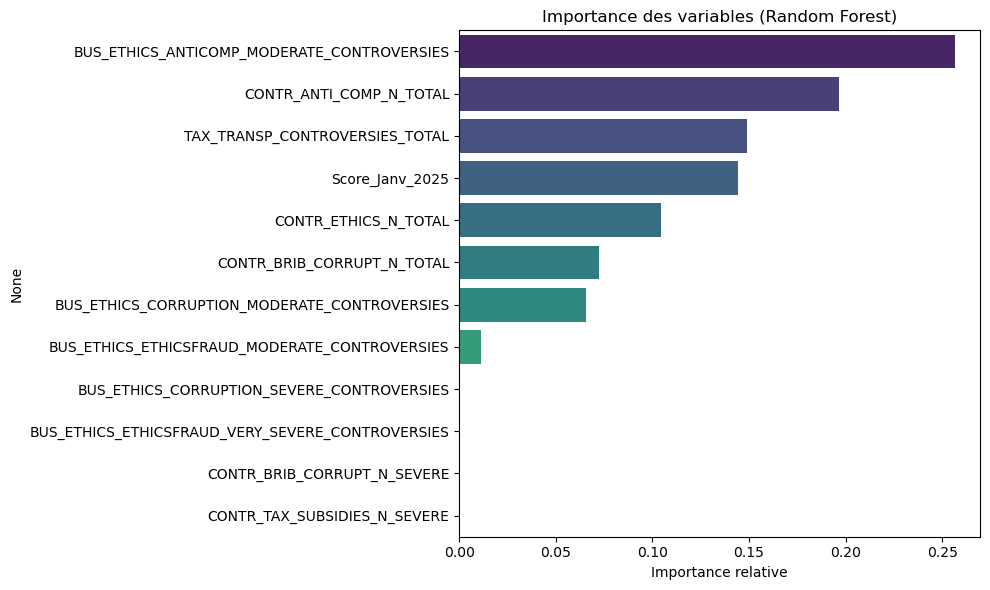

RandomForestRegressor(max_depth=5, random_state=42)

In [15]:
reg_random_forest('Governance')

✅ Random Forest Regressor
R² entraînement : 0.8058
R² test : 0.0000
R² validation croisée : 0.1783 ± 0.4122


/tmp/ipykernel_61416/2539893355.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


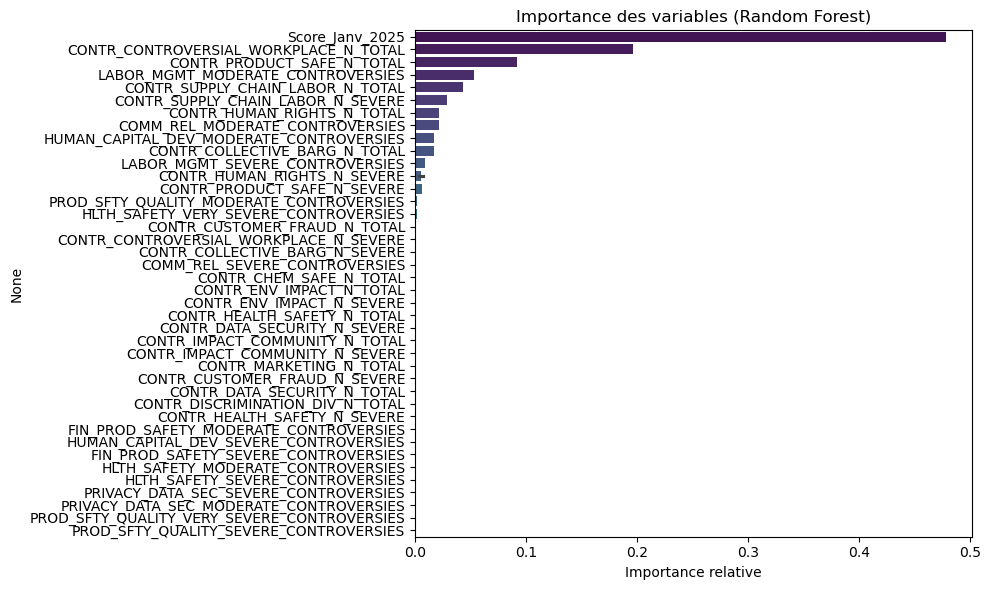

RandomForestRegressor(max_depth=5, random_state=42)

In [16]:
reg_random_forest('Social')

✅ Random Forest Regressor
R² entraînement : 0.8718
R² test : 0.0000
R² validation croisée : -0.2365 ± 0.4606


/tmp/ipykernel_61416/2539893355.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


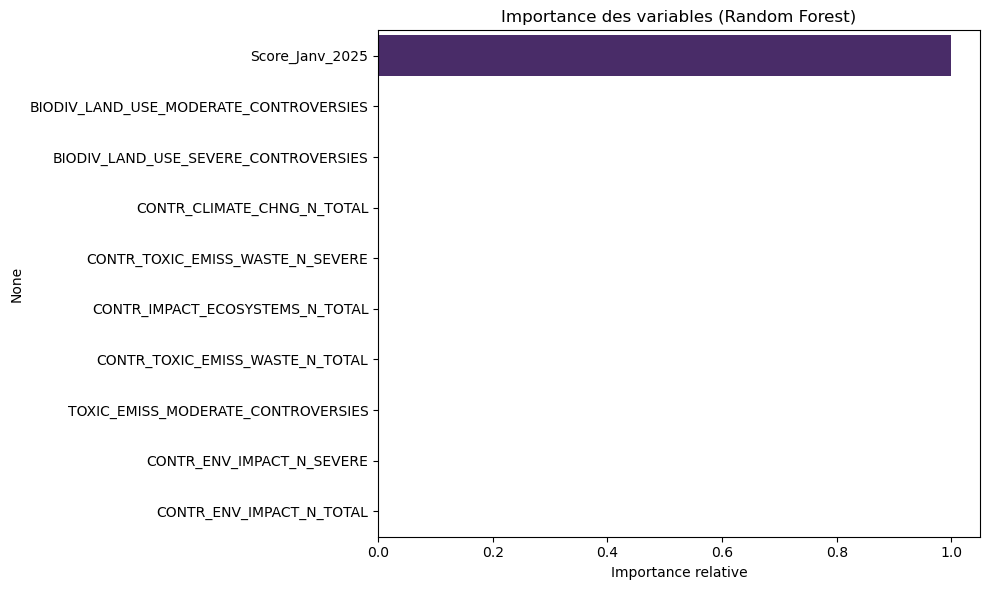

RandomForestRegressor(max_depth=5, random_state=42)

In [17]:
reg_random_forest('Environment')

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

def reg_gradient_boosting(type_score):
    df1 = création_bdd(type_score)  
    df2 = bdd_diff_consensus(type_score[0]) 

    df1 = df1.rename(columns={'Client_ID': 'isin'})
    df_merged = pd.merge(df1, df2, on='isin')

    X = df_merged.drop(columns=['isin', 'Diff']).fillna(0)
    y = df_merged['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes.")
        return

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split pour évaluation
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Gradient Boosting
    gb=GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
    gb.fit(X_train, y_train)

    # Évaluations
    r2_train = gb.score(X_train, y_train)
    r2_test = gb.score(X_test, y_test)
    cv_scores = cross_val_score(gb, X_scaled, y, cv=5, scoring='r2')

    print("✅ Gradient Boosting Regressor")
    print(f"R² entraînement : {r2_train:.4f}")
    print(f"R² test : {r2_test:.4f}")
    print(f"R² validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Variables importantes
    importances = pd.Series(gb.feature_importances_, index=df_merged.drop(columns=['isin', 'Diff']).columns)
    importances = importances.sort_values(ascending=False)

    print("\n📌 Top variables importantes :")
    print(importances.head(10))

    return gb, importances

In [19]:
reg_gradient_boosting('Governance')

✅ Gradient Boosting Regressor
R² entraînement : 0.9937
R² test : 0.0000
R² validation croisée : -0.0039 ± 0.0078

📌 Top variables importantes :
Score_Janv_2025                                     0.331304
BUS_ETHICS_ANTICOMP_MODERATE_CONTROVERSIES          0.260349
CONTR_ANTI_COMP_N_TOTAL                             0.237169
TAX_TRANSP_CONTROVERSIES_TOTAL                      0.171003
CONTR_ETHICS_N_TOTAL                                0.000137
BUS_ETHICS_CORRUPTION_MODERATE_CONTROVERSIES        0.000028
CONTR_BRIB_CORRUPT_N_TOTAL                          0.000010
BUS_ETHICS_CORRUPTION_SEVERE_CONTROVERSIES          0.000000
CONTR_BRIB_CORRUPT_N_SEVERE                         0.000000
BUS_ETHICS_ETHICSFRAUD_VERY_SEVERE_CONTROVERSIES    0.000000
dtype: float64


(GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50),
 Score_Janv_2025                                     0.331304
 BUS_ETHICS_ANTICOMP_MODERATE_CONTROVERSIES          0.260349
 CONTR_ANTI_COMP_N_TOTAL                             0.237169
 TAX_TRANSP_CONTROVERSIES_TOTAL                      0.171003
 CONTR_ETHICS_N_TOTAL                                0.000137
 BUS_ETHICS_CORRUPTION_MODERATE_CONTROVERSIES        0.000028
 CONTR_BRIB_CORRUPT_N_TOTAL                          0.000010
 BUS_ETHICS_CORRUPTION_SEVERE_CONTROVERSIES          0.000000
 CONTR_BRIB_CORRUPT_N_SEVERE                         0.000000
 BUS_ETHICS_ETHICSFRAUD_VERY_SEVERE_CONTROVERSIES    0.000000
 BUS_ETHICS_ETHICSFRAUD_MODERATE_CONTROVERSIES       0.000000
 CONTR_TAX_SUBSIDIES_N_SEVERE                        0.000000
 dtype: float64)

In [20]:
reg_gradient_boosting('Social')

✅ Gradient Boosting Regressor
R² entraînement : 0.4054
R² test : 0.0000
R² validation croisée : -0.0829 ± 0.1606

📌 Top variables importantes :
CONTR_CONTROVERSIAL_WORKPLACE_N_TOTAL       0.362946
Score_Janv_2025                             0.303192
LABOR_MGMT_MODERATE_CONTROVERSIES           0.096793
CONTR_PRODUCT_SAFE_N_TOTAL                  0.053862
PROD_SFTY_QUALITY_MODERATE_CONTROVERSIES    0.047758
CONTR_SUPPLY_CHAIN_LABOR_N_SEVERE           0.033577
CONTR_COLLECTIVE_BARG_N_TOTAL               0.024715
CONTR_HUMAN_RIGHTS_N_SEVERE                 0.023156
CONTR_SUPPLY_CHAIN_LABOR_N_TOTAL            0.018205
CONTR_HUMAN_RIGHTS_N_TOTAL                  0.016118
dtype: float64


(GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50),
 CONTR_CONTROVERSIAL_WORKPLACE_N_TOTAL          0.362946
 Score_Janv_2025                                0.303192
 LABOR_MGMT_MODERATE_CONTROVERSIES              0.096793
 CONTR_PRODUCT_SAFE_N_TOTAL                     0.053862
 PROD_SFTY_QUALITY_MODERATE_CONTROVERSIES       0.047758
 CONTR_SUPPLY_CHAIN_LABOR_N_SEVERE              0.033577
 CONTR_COLLECTIVE_BARG_N_TOTAL                  0.024715
 CONTR_HUMAN_RIGHTS_N_SEVERE                    0.023156
 CONTR_SUPPLY_CHAIN_LABOR_N_TOTAL               0.018205
 CONTR_HUMAN_RIGHTS_N_TOTAL                     0.016118
 HUMAN_CAPITAL_DEV_MODERATE_CONTROVERSIES       0.009827
 CONTR_HUMAN_RIGHTS_N_SEVERE                    0.007032
 COMM_REL_MODERATE_CONTROVERSIES                0.002820
 CONTR_ENV_IMPACT_N_TOTAL                       0.000000
 CONTR_ENV_IMPACT_N_SEVERE                      0.000000
 COMM_REL_SEVERE_CONTROVERSIES                  0.000000
 CONTR_CHE

In [21]:
reg_gradient_boosting('Environment')

✅ Gradient Boosting Regressor
R² entraînement : 0.9277
R² test : 0.0000
R² validation croisée : -0.0070 ± 0.0091

📌 Top variables importantes :
Score_Janv_2025                           1.0
BIODIV_LAND_USE_MODERATE_CONTROVERSIES    0.0
BIODIV_LAND_USE_SEVERE_CONTROVERSIES      0.0
CONTR_CLIMATE_CHNG_N_TOTAL                0.0
CONTR_TOXIC_EMISS_WASTE_N_SEVERE          0.0
CONTR_IMPACT_ECOSYSTEMS_N_TOTAL           0.0
CONTR_TOXIC_EMISS_WASTE_N_TOTAL           0.0
TOXIC_EMISS_MODERATE_CONTROVERSIES        0.0
CONTR_ENV_IMPACT_N_SEVERE                 0.0
CONTR_ENV_IMPACT_N_TOTAL                  0.0
dtype: float64


(GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50),
 Score_Janv_2025                           1.0
 BIODIV_LAND_USE_MODERATE_CONTROVERSIES    0.0
 BIODIV_LAND_USE_SEVERE_CONTROVERSIES      0.0
 CONTR_CLIMATE_CHNG_N_TOTAL                0.0
 CONTR_TOXIC_EMISS_WASTE_N_SEVERE          0.0
 CONTR_IMPACT_ECOSYSTEMS_N_TOTAL           0.0
 CONTR_TOXIC_EMISS_WASTE_N_TOTAL           0.0
 TOXIC_EMISS_MODERATE_CONTROVERSIES        0.0
 CONTR_ENV_IMPACT_N_SEVERE                 0.0
 CONTR_ENV_IMPACT_N_TOTAL                  0.0
 dtype: float64)